# Load packages and functions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import gdal

In [2]:
def readDEM(f):
    ds = gdal.Open(f)
    Z = ds.ReadAsArray()
    Z[Z<=0]=np.nan
    plt.imshow(Z,'terrain',interpolation='nearest')
    plt.colorbar()
    return Z

In [3]:
def cropToRaster(fref,finput):
    info = gdal.Info(fref, format='json')
    minX = info["cornerCoordinates"]['upperLeft'][0]
    maxX = info["cornerCoordinates"]['upperRight'][0]
    minY = info["cornerCoordinates"]['lowerLeft'][1]
    maxY = info["cornerCoordinates"]['upperLeft'][1]
    print('crop to: ',(minX, minY, maxX, maxY))
    dst = '/vsimem/Zws'
    ds = gdal.Warp(dst, finput, outputBounds=[minX, minY, maxX, maxY])
    return dst

In [4]:
def cropAndResizeToRaster(fref,finput):
    info = gdal.Info(fref, format='json')
    minX = info["cornerCoordinates"]['upperLeft'][0]
    maxX = info["cornerCoordinates"]['upperRight'][0]
    minY = info["cornerCoordinates"]['lowerLeft'][1]
    maxY = info["cornerCoordinates"]['upperLeft'][1]
    psx = info['geoTransform'][1]
    psy = info['geoTransform'][5]
    print('crop to: ',(minX, minY, maxX, maxY), 'with pixel size',(psx,psy))
    dst = '/vsimem/Zws'
    ds = gdal.Warp(dst, finput, outputBounds=(minX, minY, maxX, maxY), xRes=psx, yRes=psy)
    return dst

In [5]:
def shiftDEM(Z,shiftX,shiftY):
    M = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    shifted = cv2.warpAffine(Z, M, (Z.shape[1], Z.shape[0]),borderValue=np.nan)
    return shifted

In [6]:
def nmad(x):
    return 1.4826*np.nanmedian(abs(x - np.nanmedian(x)))

In [7]:
def err(params, Zslave, Zmaster):
    shiftX, shiftY = params 
    M = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    shifted = shiftDEM(Zslave,shiftX,shiftY)
    return nmad(shifted-Zmaster)

In [8]:
def diffDEM(Z1,Z2,userzoff=False, zoff=0):
    dlim=10
    dZ = Z1 - Z2
    if userzoff is False:
        zoff = np.nanmedian(dZ)
    print('vertical offset =', zoff)
    dZ = dZ - zoff
    fig, (ax0, ax1) = plt.subplots(1, 2)
    m = ax1.imshow(dZ,'bwr_r',vmin=-dlim,vmax=dlim, interpolation='nearest')
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    plt.colorbar
    fig.colorbar(m, ax=ax1, shrink=0.6, orientation='horizontal')
    dZma = np.ma.masked_invalid(dZ)
    print('nmad =',nmad(dZma.compressed()))
    ax0.hist(dZma.compressed(),100, range=(-dlim,dlim))
    ax0.grid(visible=True)
    return dZ

# Load and prepare data

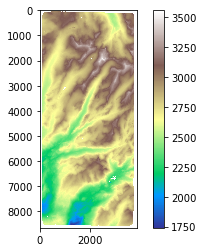

In [9]:
# summer DEM
fs = "Pleiades_Tuo_0502/PL_summer_fullmap_NnK_gdalvrt_comp.tif"
Zs = readDEM(fs)

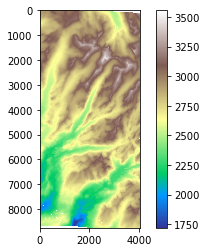

In [10]:
# winter DEM
fw = "Pleiades_Tuo_0502/201705021849264_tr3-DEM_comp.tif"
Zw = readDEM(fw)

In [11]:
print(Zw.shape, Zs.shape)

(8756, 4025) (8655, 3856)


crop to:  (269310.0, 4204731.0, 280878.0, 4230696.0)


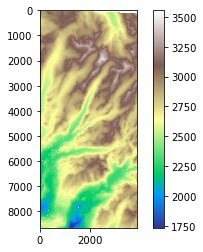

In [12]:
# superpose to summer DEM
ds = cropToRaster(fs,fw)
Zwc = readDEM(ds)

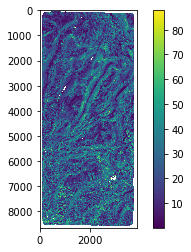

In [13]:
# load slopes from summer DEM
ds = gdal.Open(fs)
dst = '/vsimem/slopeS.tif'
gdal.DEMProcessing(dst, ds, 'slope')
slopeSummer = np.ma.masked_values(gdal.Open(dst).ReadAsArray(), -9999)
plt.imshow(slopeSummer, interpolation='nearest')
plt.colorbar();

crop to:  (269310.0, 4204731.0, 280878.0, 4230696.0) with pixel size (3.0, -3.0)


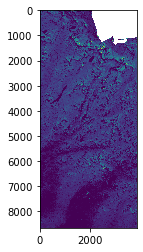

In [14]:
# load ASO SD
fsd = "Pleiades_Tuo_0502/ASO_snowdepth_20170502_clip_comp.tif"
vf = cropAndResizeToRaster(fs,fsd)
ds = gdal.Open(vf)
SD = ds.ReadAsArray()
SD[SD<0]=np.nan
plt.imshow(SD, interpolation='nearest');

# Align DEMs

In [15]:
# align winter DEM on summer DEM
initial_guess = [-1.5, -1.5]
result = optimize.minimize(err, initial_guess, args=(Zwc, Zs),method='Nelder-Mead')
if result.success:
    print("[shiftX, shiftY]", result.x)
else:
    raise ValueError(result.message)

[shiftX, shiftY] [0.3999293  2.29025868]


vertical offset = 4.929199
nmad = 3.21423046875


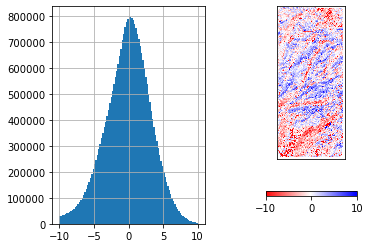

In [16]:
# Before optim 
shiftX, shiftY = 0,0 
Ztmp = shiftDEM(Zwc,shiftX,shiftY)
dZ = diffDEM(Ztmp,Zs)

0.39992929995060256 2.2902586765587363
vertical offset = 5.1748047
nmad = 2.329955126953125


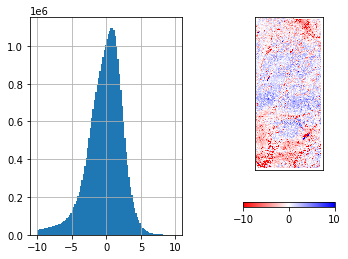

In [17]:
# After optim 
shiftX, shiftY = result.x 
print(shiftX, shiftY)
Ztmp = shiftDEM(Zwc,shiftX,shiftY)
dZ = diffDEM(Ztmp,Zs)

In [18]:
# load stable terrain in winter DEM
fm = "Pleiades_Tuo_0502/20170501_stablemask_fullmap_comp.tif"

crop to:  (269310.0, 4204731.0, 280878.0, 4230696.0) with pixel size (3.0, -3.0)


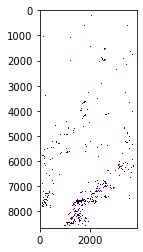

In [19]:
# superpose to summer DEM
vf = cropAndResizeToRaster(fs,fm)
ds = gdal.Open(vf)
M = ds.ReadAsArray()
M[M<=0]=np.nan
plt.imshow(M, interpolation='nearest');

In [20]:
# mask winter DEM outside stable terrain
Zws = np.where(M==1,Zwc,M)

In [21]:
# align stable terrain winter DEM on summer DEM
initial_guess = result.x
result = optimize.minimize(err, initial_guess, args=(Zws, Zs),method='Nelder-Mead')
if result.success:
    print("[shiftX, shiftY]", result.x)
else:
    raise ValueError(result.message)

[shiftX, shiftY] [0.4774156  1.54592461]


vertical offset = 1.1574707
nmad = 2.536273974609375


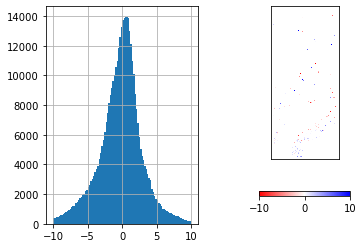

In [22]:
# Before optim 
shiftX, shiftY = 0,0 
Ztmp = shiftDEM(Zws,shiftX,shiftY)
dZ = diffDEM(Ztmp,Zs)

0.47741560181603193 1.5459246066771495
vertical offset = 3.3115234
nmad = 1.068876416015625


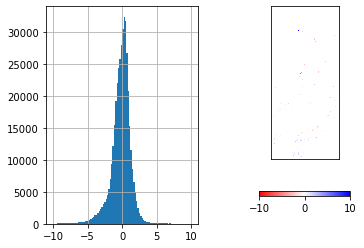

In [23]:
# After optim 
shiftX, shiftY = result.x 
print(shiftX, shiftY)
Ztmp = shiftDEM(Zws,shiftX,shiftY)
dZ = diffDEM(Ztmp,Zs)

vertical offset = 3.3830566
nmad = 0.8745023437499999


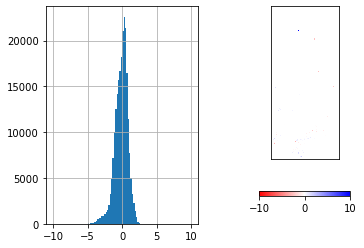

In [24]:
# get vertical offset and NMAD on slopes <40 only
Zs40 = np.where(slopeSummer<40, Zs, np.nan)
diff = diffDEM(Ztmp,Zs40)

In [25]:
# align stable terrain winter DEM on slopes < 40 of summer DEM
initial_guess = result.x
result = optimize.minimize(err, initial_guess, args=(Zws, Zs40),method='Nelder-Mead')
if result.success:
    print("[shiftX, shiftY]", result.x)
else:
    raise ValueError(result.message)

[shiftX, shiftY] [0.63257567 1.08214722]


0.6325756724062424 1.0821472246740047
vertical offset = 2.9709473
nmad = 0.846631201171875


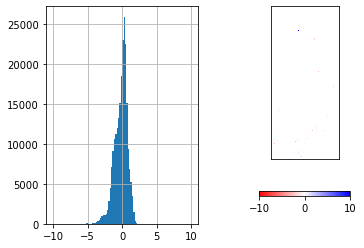

In [26]:
# After optim 
shiftX, shiftY = result.x 
print(shiftX, shiftY)
Ztmp = shiftDEM(Zws,shiftX,shiftY)
dZ = diffDEM(Ztmp,Zs40)

# Compare to ASO

## Coregistration on stable terrain, slopes < 40

vertical offset = 2.9709473
nmad = 2.555819970703125


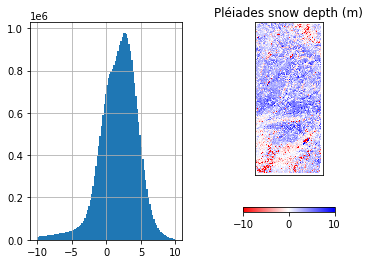

In [27]:
# Apply shift to winter DEM 
ZwOns = shiftDEM(Zwc,shiftX,shiftY)
dZ = diffDEM(ZwOns,Zs,userzoff=True, zoff=2.9709473)
plt.title("Pléiades snow depth (m)");

In [29]:
# Set snow depth to zero where no snow
# shift maskS
Mshifted = shiftDEM(M,shiftX,shiftY)
print('fraction of no snow pixels: {:.2f}%'.format(100*np.nansum(Mshifted)/Mshifted.size))
dZM = np.where(Mshifted==1,0,dZ)

fraction of no snow pixels: 1.23%


vertical offset = 0
nmad = 1.595170458984375


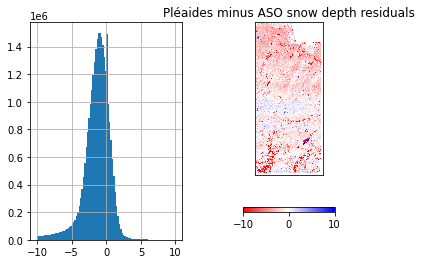

In [30]:
# compare dDEM with ASO snow depth
res = diffDEM(dZM,SD,userzoff=True, zoff=0)
plt.title("Pléaides minus ASO snow depth residuals");

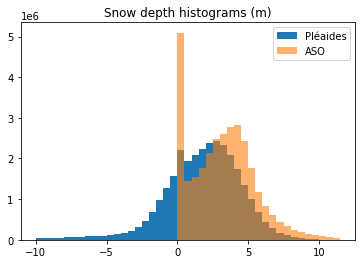

In [31]:
SDple = dZM[abs(dZM)<12].flatten()
SDaso = SD[abs(SD)<12].flatten()
b=np.arange(-10,12,0.5)
plt.hist(SDple,bins=b,density=False,label='Pléaides');
plt.hist(SDaso,bins=b,density=False, alpha=.6,label='ASO')
plt.title("Snow depth histograms (m)");
plt.legend();

In [32]:
ix = np.logical_and.reduce((abs(dZM)<12,abs(SD)<12,SD>0,dZM>0)) 
sdple=SD[ix].flatten()
sdaso=dZM[ix].flatten()

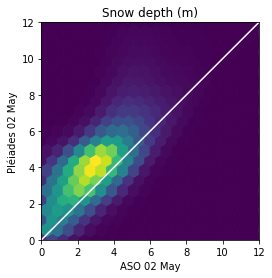

In [33]:
plt.hexbin(sdaso,sdple,gridsize=20)
plt.axis('square')
plt.xlim((0,12))
plt.ylim((0,12))
plt.plot([0,12],[0,12],'w-');
plt.xlabel("ASO 02 May")
plt.ylabel("Pléiades 02 May")
plt.title("Snow depth (m)");

## Coregistration on stable terrain, all slopes

In [34]:
shiftX, shiftY = 0.4774156, 1.54592461
zoff = 3.3115234

vertical offset = 3.3115234
nmad = 2.4291329589843746


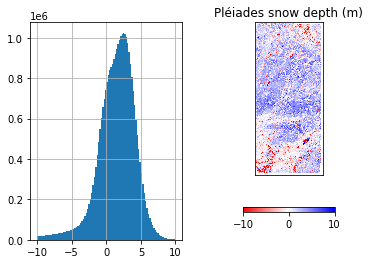

In [35]:
# Apply shift to winter DEM 
ZwOns = shiftDEM(Zwc,shiftX,shiftY)
dZ = diffDEM(ZwOns,Zs,userzoff=True, zoff=zoff)
plt.title("Pléiades snow depth (m)");

In [37]:
# Set snow depth to zero where no snow
# shift maskS
Mshifted = shiftDEM(M,shiftX,shiftY)
print('fraction of no snow pixels: {:.2f}%'.format(100*np.nansum(Mshifted)/Mshifted.size))
dZM = np.where(Mshifted==1,0,dZ)

fraction of no snow pixels: 1.23%


vertical offset = 0
nmad = 1.6153912472248078


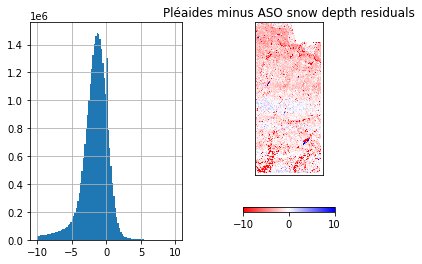

In [38]:
# compare dDEM with ASO snow depth
res = diffDEM(dZM,SD,userzoff=True, zoff=0)
plt.title("Pléaides minus ASO snow depth residuals");

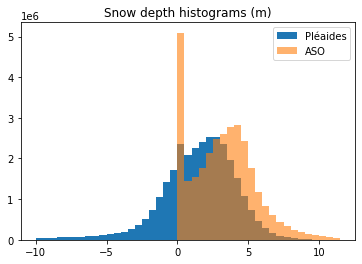

In [39]:
SDple = dZM[abs(dZM)<12].flatten()
SDaso = SD[abs(SD)<12].flatten()
b=np.arange(-10,12,0.5)
plt.hist(SDple,bins=b,density=False,label='Pléaides');
plt.hist(SDaso,bins=b,density=False, alpha=.6,label='ASO')
plt.title("Snow depth histograms (m)");
plt.legend();

In [40]:
ix = np.logical_and.reduce((abs(dZM)<12,abs(SD)<12,SD>0,dZM>0)) 
sdple=SD[ix].flatten()
sdaso=dZM[ix].flatten()

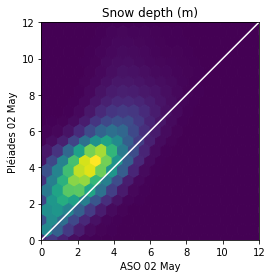

In [41]:
plt.hexbin(sdaso,sdple,gridsize=20)
plt.axis('square')
plt.xlim((0,12))
plt.ylim((0,12))
plt.plot([0,12],[0,12],'w-');
plt.xlabel("ASO 02 May")
plt.ylabel("Pléiades 02 May")
plt.title("Snow depth (m)");